# Learning to Reweight Examples for Robust Deep Learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from dotPyfiles.LeNet import *
from dotPyfiles.class_imbalance_dataset import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\eshaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hyperparameters = {
    'lr' : 1e-3,
    'momentum' : 0.9,
    'batch_size' : 100,
    'num_iterations' : 4000,
}

### Dataset
Following the class imbalance experiment in the paper, we used numbers 9 and 4 of the MNIST dataset to form a highly imbalanced dataset where 9 is the dominating class. The test set on the other hand is balanced.

In [3]:
data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[8, 0], proportion=0.99995, mode="train")
test_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[8, 0], proportion=0.5, mode="test")

C:\Users\eshaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\eshaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\eshaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\eshaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\datasets\mnist.py:70: UserWa

In [4]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [5]:
val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)

In [6]:
def get_LeNet():
    model = LeNet(n_out=1)

    if torch.cuda.is_available():
        model.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(model.params(),lr=hyperparameters["lr"])
    
    return model, opt

LeNet

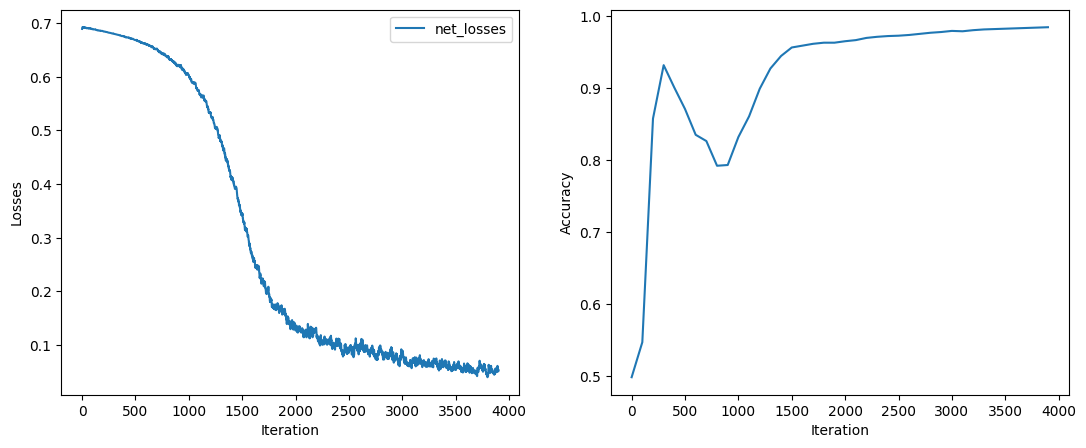

100%|██████████| 4000/4000 [06:31<00:00, 10.22it/s]


In [7]:
net, opt = get_LeNet()

net_losses = []
plot_step = 100
net_l = 0

smoothing_alpha = 0.9
accuracy_log = []
for i in tqdm(range(hyperparameters['num_iterations'])):
    net.train()
    image, labels = next(iter(data_loader))

    image = to_var(image, requires_grad=False)
    # print(image.shape)
    labels = to_var(labels, requires_grad=False)

    # y = net.forward(image.view(image.size(0), -1))    
    # cost = F.binary_cross_entropy_with_logits(y, labels.unsqueeze(1))
    y = net(image) #LeNet
    cost = F.binary_cross_entropy_with_logits(y, labels) # LeNet
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
    net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
    
    if i % plot_step == 0:
        net.eval()
        
        acc = []
        for itr,(test_img, test_label) in enumerate(test_loader):
            test_img = to_var(test_img, requires_grad=False)
            test_label = to_var(test_label, requires_grad=False)
            
            output = net(test_img) #LeNet
            # output = net.forward(test_img.view(test_img.size(0), -1)) 
            predicted = (F.sigmoid(output) > 0.5).int()
            
            acc.append((predicted.int() == test_label.int()).float())

        accuracy = torch.cat(acc,dim=0).mean()
        accuracy_log.append(np.array([i,accuracy])[None])
        
        
        IPython.display.clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(13,5))
        ax1, ax2 = axes.ravel()

        ax1.plot(net_losses, label='net_losses')
        ax1.set_ylabel("Losses")
        ax1.set_xlabel("Iteration")
        ax1.legend()
        
        acc_log = np.concatenate(accuracy_log, axis=0)
        ax2.plot(acc_log[:,0],acc_log[:,1])
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Iteration')
        plt.show()


<img src="pseudocode.PNG" width="300" />



In [8]:
def train_lre():
    net, opt = get_LeNet()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(hyperparameters['num_iterations'])):
        net.train()
        image, labels = next(iter(data_loader))
      
        meta_net = LeNet(n_out=1)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels, requires_grad=False)

        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(hyperparameters['lr'], source_params=grads)
        
        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
    return np.mean(acc_log[-6:-1, 1])

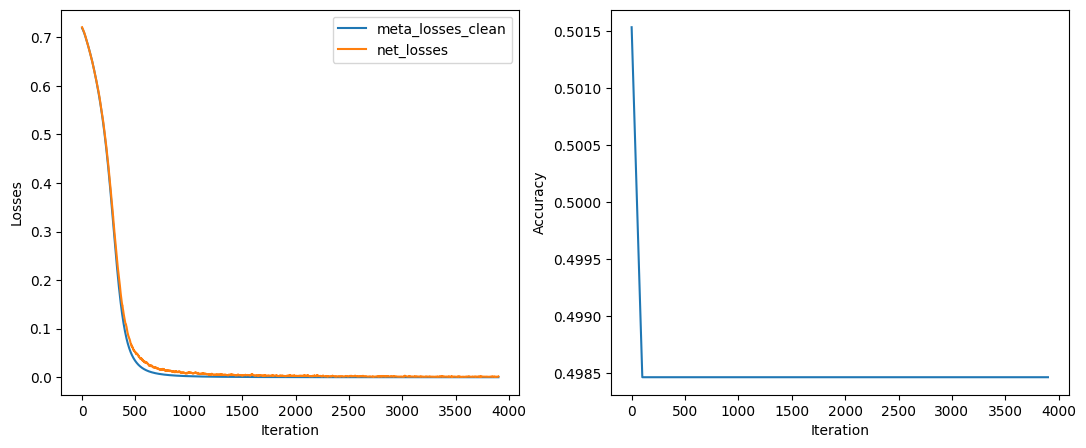

100%|██████████| 4000/4000 [13:47<00:00,  4.83it/s]


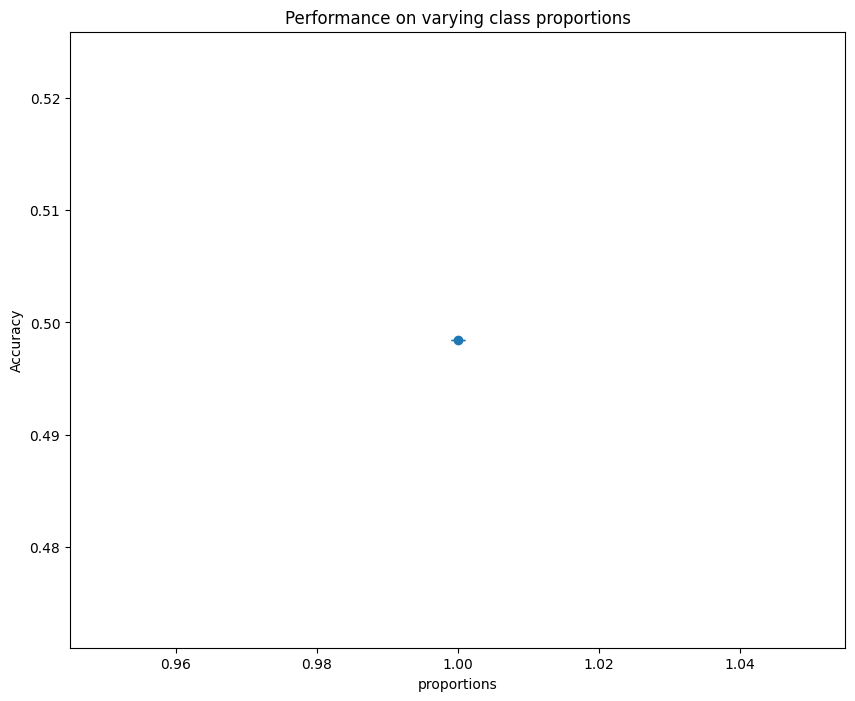

In [9]:
num_repeats = 1
# proportions = [0.9,0.95, 0.98, 0.99, 0.995]
# proportions = [0.9,0.99,0.99995]
proportions = [0.99995]

accuracy_log = {}

for prop in proportions:
    data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[8, 0], proportion=prop, mode="train")
    val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
    val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)
    
    for k in range(num_repeats):
        accuracy = train_lre()
        
        if prop in accuracy_log:
            accuracy_log[prop].append(accuracy)
        else:
            accuracy_log[prop] = [accuracy]

plt.figure(figsize=(10,8))
for prop in proportions:
    accuracies = accuracy_log[prop]
    plt.scatter([prop] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_log.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_log.items())])
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Performance on varying class proportions')
plt.xlabel('proportions')
plt.ylabel('Accuracy')
plt.show()

We can see that even at 0.995 proportion of the dominant class in the training data, the model still reaches 90+% accuracy on the balanced test data.

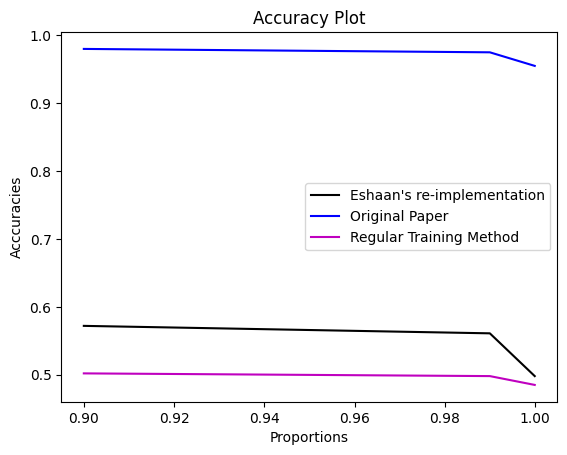

In [10]:
# print(accuracies_mean)
theirs = [0.98,0.975,0.955]
ours = [0.572, 0.561, 0.498]
reg_training = [0.502, 0.498, 0.485]
props = [0.9, 0.99, 0.99995]

plt.plot(props, ours,c='k',label="Eshaan's re-implementation")
plt.plot(props, theirs,c='b',label="Original Paper")
plt.plot(props, reg_training,c='m', label="Regular Training Method")


plt.title("Accuracy Plot")
plt.xlabel("Proportions")
plt.ylabel("Acccuracies")
plt.legend()
# plt.plot(props, ours)
# plt.plot(props,theirs)
# plt.title('Performance on varying class proportions')
# plt.xlabel('proportions')
# plt.ylabel('Accuracy')
# plt.show()

Percentage decrease between 0.98000000 and 0.97500000 is 0.51%
Percentage decrease between 0.97500000 and 0.95500000 is 2.05%


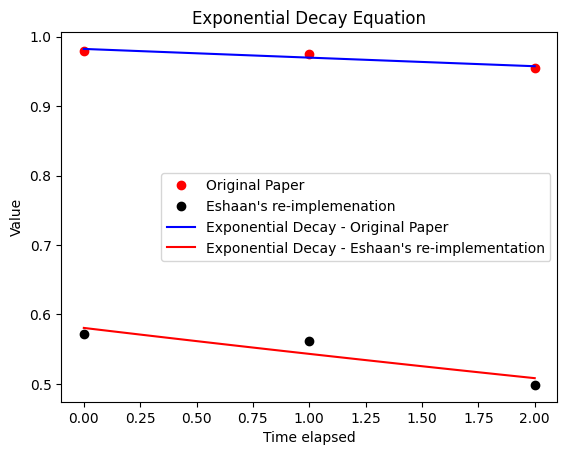

In [11]:
# values = [0.57205732, 0.56141249, 0.49846467]
values = [0.98,0.975,0.955]

for i in range(len(values)-1):
    old_value = values[i]
    new_value = values[i+1]
    percentage_decrease = ((old_value - new_value) / old_value) * 100
    print(f"Percentage decrease between {old_value:.8f} and {new_value:.8f} is {percentage_decrease:.2f}%")

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential decay function
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

# Input data
x = np.array([0, 1, 2])
y1 = np.array([0.98,0.975,0.955])
y2 = np.array([0.57205732, 0.56141249, 0.49846467])
# Fit the exponential decay function to the data
popt1, pcov1 = curve_fit(exp_decay, x, y1)
popt2, pcov2 =  curve_fit(exp_decay, x, y2)
# Generate a curve based on the fitted parameters
x_curve = np.linspace(0, 2, 100)
y1_curve = exp_decay(x_curve, *popt1)
y2_curve = exp_decay(x_curve, *popt2)

# Plot the data and the curve
plt.plot(x, y1, 'ro', label='Original Paper')
plt.plot(x,y2,'ko',label = "Eshaan's re-implemenation")
plt.plot(x_curve, y1_curve, 'b-', label='Exponential Decay - Original Paper')
plt.plot(x_curve, y2_curve, 'r-', label="Exponential Decay - Eshaan's re-implementation")
plt.title ('Exponential Decay Equation')
plt.xlabel('Time elapsed')
plt.ylabel('Value')
plt.legend()
plt.show()
